In [ ]:
# # Cell X — Robust unzip (handles some corrupted ZIPs better than Python zipfile)

# from pathlib import Path
# import subprocess

# zip_path = Path("BCICIV_2b_gdf.zip")   # <-- your zip name
# extract_dir = zip_path.parent / zip_path.stem

# assert zip_path.exists(), f"Zip not found: {zip_path.resolve()}"

# if extract_dir.exists() and any(extract_dir.iterdir()):
#     print(f"Already extracted: {extract_dir}")
# else:
#     extract_dir.mkdir(parents=True, exist_ok=True)

#     # 1) Integrity test (optional but useful)
#     print("Testing zip integrity...")
#     test = subprocess.run(["unzip", "-t", str(zip_path)], capture_output=True, text=True)
#     print(test.stdout[-1000:])  # show tail
#     if test.returncode != 0:
#         print("⚠️ unzip test reported issues. Will still attempt extraction with tolerant tools...")

#     # 2) Try unzip first
#     print(f"Extracting to: {extract_dir}")
#     r = subprocess.run(["unzip", "-o", str(zip_path), "-d", str(extract_dir)], capture_output=True, text=True)
#     if r.returncode == 0:
#         print("✅ Extracted with unzip")
#     else:
#         print("unzip failed, trying 7z fallback...")
#         # 3) Fallback: 7z (often succeeds when unzip/zipfile fail)
#         r2 = subprocess.run(["7z", "x", "-y", f"-o{extract_dir}", str(zip_path)], capture_output=True, text=True)
#         if r2.returncode == 0:
#             print("✅ Extracted with 7z")
#         else:
#             print("❌ Extraction failed with both unzip and 7z.")
#             print("---- unzip stderr ----")
#             print(r.stderr[-2000:])
#             print("---- 7z stderr ----")
#             print(r2.stderr[-2000:])
#             raise RuntimeError("Archive appears corrupted. Please re-download/re-upload the ZIP.")


Testing zip integrity...
 testing: B0503T.gdf               OK
    testing: B0504E.gdf               OK
    testing: B0505E.gdf               OK
    testing: B0601T.gdf               OK
    testing: B0602T.gdf               OK
    testing: B0603T.gdf               OK
    testing: B0604E.gdf               OK
    testing: B0605E.gdf               OK
    testing: B0701T.gdf               OK
    testing: B0702T.gdf               OK
    testing: B0703T.gdf               OK
    testing: B0704E.gdf               OK
    testing: B0705E.gdf               OK
    testing: B0801T.gdf               OK
    testing: B0802T.gdf               OK
    testing: B0803T.gdf               OK
    testing: B0804E.gdf               OK
    testing: B0805E.gdf               OK
    testing: B0901T.gdf               OK
    testing: B0902T.gdf               OK
    testing: B0903T.gdf               OK
    testing: B0904E.gdf               OK
    testing: B0905E.gdf               OK
No errors detected in compressed da

In [ ]:
%pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 61.7 MB/s eta 0:00:00


In [31]:
# Cell 1
# Purpose: Import all libraries needed for preprocessing and GAN training.

import numpy as np
import mne
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

print("Libraries imported successfully.")


Libraries imported successfully.


/home/glider/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
# =========================
# REPLACE your current "Cell 2 — Config" with this (FIXES the x_fake bug too)
# =========================

DATA_DIR = Path("BCICIV_2b_gdf")          # folder containing *T.gdf
T_FILES = sorted(DATA_DIR.glob("*T.gdf"))

EVENT_KEYS = {"left": "769", "right": "770"}

TMIN, TMAX = 0.0, 4.0
L_FREQ, H_FREQ = 0.5, 40.0
NOTCH_HZ = 50.0
EOG_REJECT_UV = 150.0
RESAMPLE_HZ = 250
CLIP_UV = 100.0

BATCH_SIZE = 32
EPOCHS = 500
Z_DIM = 128

# TTUR (keep)
LR_D = 1e-4
LR_G = 2e-4
LR = LR_D  # keep for backward compatibility if other cells reference it

# You said: DO NOT change N_CRITIC scheduling -> keep as-is
N_CRITIC = 5

# Recommended for EEG: reduce GP domination a bit (helps avoid over-smooth / tiny amplitude)
LAMBDA_GP = 5.0

# Generator regularizers (properly used in training loop below)
LAMBDA_PSD = 0.10     # was 0.03 in your loop; start at 0.10 (0.05–0.30 is common)
LAMBDA_SMOOTH = 1e-4  # small; keep small or it will over-smooth

# Optional: clip generator gradients for stability
GRAD_CLIP_G = 10.0  # set None to disable

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Found T files:", [f.name for f in T_FILES])
print("DEVICE:", DEVICE)
print(f"LR_D={LR_D}, LR_G={LR_G}, N_CRITIC={N_CRITIC}, LAMBDA_GP={LAMBDA_GP}, LAMBDA_PSD={LAMBDA_PSD}, LAMBDA_SMOOTH={LAMBDA_SMOOTH}")


Found T files: ['B0101T.gdf', 'B0102T.gdf', 'B0103T.gdf', 'B0201T.gdf', 'B0202T.gdf', 'B0203T.gdf', 'B0301T.gdf', 'B0302T.gdf', 'B0303T.gdf', 'B0401T.gdf', 'B0402T.gdf', 'B0403T.gdf', 'B0501T.gdf', 'B0502T.gdf', 'B0503T.gdf', 'B0601T.gdf', 'B0602T.gdf', 'B0603T.gdf', 'B0701T.gdf', 'B0702T.gdf', 'B0703T.gdf', 'B0801T.gdf', 'B0802T.gdf', 'B0803T.gdf', 'B0901T.gdf', 'B0902T.gdf', 'B0903T.gdf']
DEVICE: cuda
LR_D=0.0001, LR_G=0.0002, N_CRITIC=5, LAMBDA_GP=5.0, LAMBDA_PSD=0.1, LAMBDA_SMOOTH=0.0001


In [33]:
# Cell 3
# Purpose: Define preprocessing for ONE T file (filter → epoch → EOG reject → drop EOG).

def preprocess_one_file(gdf_path: Path):
    raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)

    # mark EOG channels
    for ch in raw.ch_names:
        if "EOG" in ch.upper():
            raw.set_channel_types({ch: "eog"})

    # filter
    raw.filter(L_FREQ, H_FREQ, verbose=False)
    raw.notch_filter(NOTCH_HZ, verbose=False)

    # events
    events, event_id_all = mne.events_from_annotations(raw, verbose=False)

    event_id = {
        "left": event_id_all[EVENT_KEYS["left"]],
        "right": event_id_all[EVENT_KEYS["right"]],
    }

    # epoch EEG+EOG
    epochs = mne.Epochs(
        raw, events, event_id=event_id,
        tmin=TMIN, tmax=TMAX,
        picks=mne.pick_types(raw.info, eeg=True, eog=True),
        baseline=None,
        preload=True,
        verbose=False,
    )

    # EOG rejection
    eog_picks = mne.pick_types(epochs.info, eog=True)
    X = epochs.get_data()
    X_eog = X[:, eog_picks, :]
    ptp_uv = (X_eog.max(-1) - X_eog.min(-1)) * 1e6
    bad_idx = np.where(ptp_uv.max(axis=1) > EOG_REJECT_UV)[0]
    epochs.drop(bad_idx)

    # drop EOG
    epochs = epochs.pick_types(eeg=True)

    # resample
    epochs.resample(RESAMPLE_HZ, verbose=False)

    # labels → 0/1
    y = epochs.events[:, 2]
    y = np.array([0 if v == event_id["left"] else 1 for v in y])

    return epochs.get_data(), y

print("Preprocessing function defined.")


Preprocessing function defined.


In [34]:
# Cell 4
# Purpose: Apply preprocessing to all T files and concatenate epochs in memory.

X_all, y_all = [], []

for f in T_FILES:
    print("Processing:", f.name)
    X_i, y_i = preprocess_one_file(f)
    print("  epochs:", X_i.shape[0])
    X_all.append(X_i)
    y_all.append(y_i)

X = np.concatenate(X_all, axis=0)
y = np.concatenate(y_all, axis=0)

print("Final dataset shape X:", X.shape)
print("Final labels shape y:", y.shape)
print("Label counts:", {0: int((y==0).sum()), 1: int((y==1).sum())})


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Processing: B0101T.gdf


Dropped 3 epochs: 27, 60, 80
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 117
Processing: B0102T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 2 epochs: 0, 98
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 118
Processing: B0103T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 69 epochs: 1, 10, 15, 18, 20, 26, 27, 29, 30, 31, 32, 33, 35, 36, 37, 38, 41, 45, 50, 52, 54, 55, 56, 58, 60, 62, 63, 64, 65, 67, 70, 72, 75, 77, 79, 81, 82, 92, 98, 103, 106, 113, 114, 115, 117, 118, 123, 124, 127, 128, 129, 131, 132, 133, 134, 135, 137, 144, 145, 146, 150, 152, 153, 154, 155, 156, 157, 158, 159
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 91
Processing: B0201T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 4 epochs: 2, 4, 18, 29
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 116
Processing: B0202T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 2 epochs: 45, 52
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 118
Processing: B0203T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 11 epochs: 4, 33, 91, 93, 109, 115, 117, 127, 128, 133, 138
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 149
Processing: B0301T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 27 epochs: 13, 17, 24, 25, 26, 27, 31, 32, 41, 42, 45, 50, 51, 53, 55, 57, 64, 73, 76, 79, 84, 86, 89, 95, 106, 109, 116
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 93
Processing: B0302T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 16 epochs: 1, 18, 25, 29, 40, 45, 49, 59, 61, 64, 87, 89, 92, 100, 112, 116
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 104
Processing: B0303T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 59 epochs: 1, 2, 4, 11, 12, 16, 17, 18, 19, 20, 23, 28, 31, 36, 40, 41, 44, 45, 46, 49, 50, 51, 53, 57, 58, 59, 60, 61, 63, 67, 68, 74, 78, 83, 90, 91, 92, 93, 100, 101, 105, 108, 113, 115, 119, 120, 121, 122, 124, 129, 132, 133, 135, 137, 138, 143, 145, 150, 153
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 101
Processing: B0401T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 37 epochs: 1, 2, 3, 4, 7, 19, 25, 27, 29, 31, 38, 39, 40, 48, 50, 56, 58, 71, 72, 74, 76, 77, 83, 89, 91, 92, 94, 95, 97, 98, 102, 103, 104, 112, 116, 118, 119
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 83
Processing: B0402T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 17 epochs: 25, 33, 36, 51, 63, 84, 88, 92, 101, 109, 110, 117, 118, 119, 124, 131, 134
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 123
Processing: B0403T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 16 epochs: 7, 14, 16, 18, 35, 45, 57, 61, 62, 76, 89, 103, 109, 135, 140, 153
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 144
Processing: B0501T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 1 epoch: 30
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 119
Processing: B0502T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 28 epochs: 0, 4, 8, 9, 10, 25, 40, 50, 51, 54, 57, 78, 94, 95, 96, 98, 101, 102, 103, 106, 115, 122, 126, 128, 129, 132, 134, 139
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 112
Processing: B0503T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 67 epochs: 2, 4, 5, 6, 7, 11, 13, 15, 16, 17, 20, 21, 22, 23, 24, 26, 27, 29, 33, 37, 43, 48, 49, 50, 53, 55, 56, 58, 61, 62, 64, 65, 67, 68, 79, 81, 82, 84, 88, 90, 104, 107, 112, 115, 117, 123, 125, 126, 128, 130, 132, 133, 134, 136, 137, 138, 139, 140, 141, 143, 144, 146, 149, 151, 156, 157, 158
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 93
Processing: B0601T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 15 epochs: 8, 9, 10, 14, 15, 17, 18, 19, 22, 34, 48, 52, 53, 104, 118
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 105
Processing: B0602T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 6 epochs: 22, 26, 33, 44, 82, 89
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 114
Processing: B0603T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 7 epochs: 21, 36, 37, 46, 129, 132, 137
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 153
Processing: B0701T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 10 epochs: 0, 2, 4, 5, 11, 59, 68, 77, 99, 102
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 110
Processing: B0702T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 10 epochs: 15, 22, 27, 28, 31, 57, 58, 108, 110, 119
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 110
Processing: B0703T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 31 epochs: 3, 18, 29, 47, 56, 62, 73, 74, 78, 79, 83, 86, 87, 90, 91, 97, 102, 103, 108, 111, 115, 116, 120, 123, 124, 139, 149, 151, 152, 153, 157
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 129
Processing: B0801T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 105 epochs: 0, 4, 5, 6, 8, 10, 11, 15, 17, 18, 23, 25, 29, 30, 32, 33, 35, 36, 37, 40, 41, 42, 45, 46, 47, 48, 49, 50, 52, 54, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 85, 86, 87, 88, 90, 93, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 111, 113, 114, 115, 116, 117, 118, 120, 121, 122, 124, 125, 126, 127, 128, 133, 134, 135, 136, 137, 138, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 156
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 55
Processing: B0802T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 72 epochs: 0, 2, 3, 4, 6, 7, 14, 15, 16, 17, 19, 20, 21, 22, 24, 29, 32, 33, 34, 35, 38, 41, 43, 46, 56, 57, 58, 60, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 78, 79, 80, 81, 82, 84, 88, 89, 90, 92, 93, 97, 98, 99, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 48
Processing: B0803T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 17 epochs: 0, 4, 6, 20, 43, 47, 55, 61, 63, 119, 147, 150, 152, 153, 157, 158, 159
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 143
Processing: B0901T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 3 epochs: 55, 71, 104
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 117
Processing: B0902T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 3 epochs: 29, 67, 109
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 117
Processing: B0903T.gdf


/tmp/ipykernel_2402/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 8 epochs: 10, 11, 49, 60, 97, 109, 142, 157
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 152
Final dataset shape X: (3034, 3, 1001)
Final labels shape y: (3034,)
Label counts: {0: 1524, 1: 1510}


In [35]:
# Cell 5
# Purpose: Convert EEG to GAN-friendly scale [-1, 1].

X = X * 1e6                # volts → microvolts
X = np.clip(X, -CLIP_UV, CLIP_UV)
X = (X / CLIP_UV).astype(np.float32)

print("After normalization:")
print("  min:", X.min(), "max:", X.max())
print("  dtype:", X.dtype)


After normalization:
  min: -1.0 max: 0.48452762
  dtype: float32


In [36]:
# Cell 6
# Purpose: Wrap EEG data into PyTorch Dataset and DataLoader.

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = EEGDataset(X, y)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

xb, yb = next(iter(loader))
print("One batch shape:", xb.shape)
print("Batch labels:", yb[:10].tolist())


One batch shape: torch.Size([32, 3, 1001])
Batch labels: [1, 0, 1, 1, 1, 0, 0, 0, 1, 0]


In [37]:
# =========================
# REPLACE your current "Cell 7 — Generator" with this (Residual + Multi-scale + Stronger Conditioning)
# =========================

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiScaleConv1d(nn.Module):
    """Parallel convs with different kernel sizes; summed (keeps channel count stable)."""
    def __init__(self, channels: int, kernels=(3, 7, 15, 31)):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(channels, channels, k, padding=k//2) for k in kernels
        ])

    def forward(self, x):
        out = 0.0
        for conv in self.convs:
            out = out + conv(x)
        return out / len(self.convs)

class ResBlock1d(nn.Module):
    """Residual block + conditional bias injection."""
    def __init__(self, channels: int, cond_dim: int, use_multiscale: bool = True):
        super().__init__()
        self.use_multiscale = use_multiscale

        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)

        self.ms = MultiScaleConv1d(channels) if use_multiscale else nn.Identity()

        # Condition injection: cond -> (B, channels) -> add as bias (FiLM-lite)
        self.cond_to_bias = nn.Linear(cond_dim, channels)

        self.act = nn.LeakyReLU(0.2)

    def forward(self, x, cond):
        # cond bias
        b = self.cond_to_bias(cond).unsqueeze(-1)  # (B, ch, 1)

        h = self.conv1(x)
        h = h + b
        h = self.act(h)

        h = self.ms(h)
        h = self.act(h)

        h = self.conv2(h)
        h = h + b

        return self.act(x + 0.5 * h)  # residual

class UpBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, cond_dim: int):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size=5, padding=2)
        self.res = ResBlock1d(out_ch, cond_dim, use_multiscale=True)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x, cond):
        x = self.up(x)
        x = self.act(self.conv(x))
        x = self.res(x, cond)
        return x

class Generator(nn.Module):
    """
    Conditional EEG generator:
    z + label embedding -> feature map -> upsample/resblocks -> (B,C,T)
    """
    def __init__(self, z_dim: int, n_classes: int, C: int, T: int,
                 base_ch: int = 256, cond_dim: int = 64):
        super().__init__()
        self.C, self.T = C, T
        self.z_dim = z_dim
        self.cond_dim = cond_dim

        # label embedding -> condition vector
        self.y_embed = nn.Embedding(n_classes, cond_dim)

        # Start length (upsample x2 four times => *16)
        self.L0 = int(math.ceil(T / 16))
        self.fc = nn.Sequential(
            nn.Linear(z_dim + cond_dim, base_ch * self.L0),
            nn.LeakyReLU(0.2),
        )

        self.up1 = UpBlock(base_ch, base_ch // 2, cond_dim)   # 256 -> 128
        self.up2 = UpBlock(base_ch // 2, base_ch // 4, cond_dim)  # 128 -> 64
        self.up3 = UpBlock(base_ch // 4, base_ch // 8, cond_dim)  # 64 -> 32
        self.up4 = UpBlock(base_ch // 8, base_ch // 16, cond_dim) # 32 -> 16

        self.to_out = nn.Sequential(
            nn.Conv1d(base_ch // 16, C, kernel_size=7, padding=3),
            nn.Tanh()
        )

    def forward(self, z: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        cond = self.y_embed(y)  # (B, cond_dim)

        x = torch.cat([z, cond], dim=1)  # (B, z_dim + cond_dim)
        x = self.fc(x).view(z.size(0), -1, self.L0)  # (B, base_ch, L0)

        x = self.up1(x, cond)
        x = self.up2(x, cond)
        x = self.up3(x, cond)
        x = self.up4(x, cond)

        x = self.to_out(x)  # (B, C, ~T)

        # crop/pad to exact T (handles odd-length like 1001)
        if x.size(-1) > self.T:
            x = x[..., :self.T]
        elif x.size(-1) < self.T:
            x = F.pad(x, (0, self.T - x.size(-1)))

        return x

print("Upgraded Generator defined.")


Upgraded Generator defined.


In [38]:
# =========================
# REPLACE your current "Cell 8 — Critic" with this (Projection Discriminator + Conv feature extractor)
# =========================

from torch.nn.utils import spectral_norm

class Critic(nn.Module):
    """
    Projection discriminator:
      D(x,y) = w^T h(x) + <E(y), h(x)>
    where h(x) is a learned feature vector from conv stack.
    """
    def __init__(self, n_classes: int, C: int, T: int,
                 base_ch: int = 64, feat_dim: int = 256):
        super().__init__()
        self.C, self.T = C, T

        # Conv feature extractor (1D)
        self.conv = nn.Sequential(
            spectral_norm(nn.Conv1d(C, base_ch, 7, padding=3)),
            nn.LeakyReLU(0.2),

            spectral_norm(nn.Conv1d(base_ch, base_ch*2, 5, stride=2, padding=2)),
            nn.LeakyReLU(0.2),

            spectral_norm(nn.Conv1d(base_ch*2, base_ch*4, 5, stride=2, padding=2)),
            nn.LeakyReLU(0.2),

            spectral_norm(nn.Conv1d(base_ch*4, base_ch*4, 5, stride=2, padding=2)),
            nn.LeakyReLU(0.2),
        )

        # pool -> feature vector
        self.pool = nn.AdaptiveAvgPool1d(1)

        # map to feat_dim
        self.fc_feat = nn.Sequential(
            spectral_norm(nn.Linear(base_ch*4, feat_dim)),
            nn.LeakyReLU(0.2),
        )

        # unconditional head
        self.fc_out = spectral_norm(nn.Linear(feat_dim, 1))

        # projection embedding
        self.y_embed = nn.Embedding(n_classes, feat_dim)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        h = self.conv(x)                 # (B, ch, L)
        h = self.pool(h).squeeze(-1)     # (B, ch)
        h = self.fc_feat(h)              # (B, feat_dim)

        out = self.fc_out(h).squeeze(-1) # (B,)

        # projection term: dot(h, emb(y))
        ey = self.y_embed(y)             # (B, feat_dim)
        proj = (h * ey).sum(dim=1)       # (B,)

        return out + proj

print("Upgraded Critic (Projection D) defined.")


Upgraded Critic (Projection D) defined.


In [39]:
# =========================
# REPLACE your current "Cell 9 — gradient_penalty" with this (same math, works with new D)
# =========================

def gradient_penalty(D, real, fake, y):
    """
    Standard WGAN-GP gradient penalty on interpolated samples.
    real/fake: (B,C,T), y: (B,)
    """
    B = real.size(0)
    alpha = torch.rand(B, 1, 1, device=real.device)
    interp = alpha * real + (1 - alpha) * fake
    interp.requires_grad_(True)

    d_interp = D(interp, y)  # (B,)
    grads = torch.autograd.grad(
        outputs=d_interp,
        inputs=interp,
        grad_outputs=torch.ones_like(d_interp),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]  # (B,C,T)

    grads = grads.view(B, -1)
    gp = ((grads.norm(2, dim=1) - 1.0) ** 2).mean()
    return gp


In [40]:
# Cell 10
# Purpose: Initialize Generator, Critic, and optimizers.

C, T = X.shape[1], X.shape[2]

G = Generator(Z_DIM, 2, C, T).to(DEVICE)
D = Critic(2, C, T).to(DEVICE)

# NEW: TTUR learning rates
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G, betas=(0.5, 0.9))
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D, betas=(0.5, 0.9))

print("Models initialized on device:", DEVICE)
print(f"Optimizers: lrD={LR_D}, lrG={LR_G}")


Models initialized on device: cuda
Optimizers: lrD=0.0001, lrG=0.0002


In [41]:
# Cell 11
# Purpose: Setup checkpoint saving (self-contained so later cells won't NameError)

from pathlib import Path

SAVE_DIR = Path("./checkpoints")
SAVE_DIR.mkdir(exist_ok=True)

def save_models(epoch, G, D, opt_G, opt_D, save_dir):
    path = save_dir / f"better_wgan_gp_epoch_{epoch:04d}.pt"
    torch.save(
        {
            "epoch": epoch,
            "generator_state": G.state_dict(),
            "critic_state": D.state_dict(),
            "opt_G_state": opt_G.state_dict(),
            "opt_D_state": opt_D.state_dict(),
        },
        path,
    )
    return path  # return path so we can show it in tqdm without printing a lot

print("Checkpoint directory:", SAVE_DIR.resolve())


Checkpoint directory: /home/glider/gans_eeg/normal_gans/checkpoints


In [42]:
# =========================
# MODIFY your training loop "Cell 12" like this:
# - Keep N_CRITIC unchanged (you requested that)
# - Use PSD loss (already there) + add proper smoothness penalty
# - Keep grad clipping for G
# =========================

# --- PSD helper (keep GPU-friendly) ---
def batch_log_psd(x: torch.Tensor) -> torch.Tensor:
    Xf = torch.fft.rfft(x, dim=-1)
    psd = (Xf.real**2 + Xf.imag**2)
    return torch.log(psd + 1e-8).mean(dim=0)  # (C, F)

D_loss_history = []
G_loss_history = []

SAVE_EVERY = 25

epoch_bar = tqdm(range(EPOCHS), desc="Training Epochs")

for epoch in epoch_bar:
    d_losses, g_losses = [], []

    batch_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for x_real, y_real in batch_bar:
        x_real, y_real = x_real.to(DEVICE), y_real.to(DEVICE)

        # ---- Train Critic ----
        for _ in range(N_CRITIC):
            z = torch.randn(x_real.size(0), Z_DIM, device=DEVICE)
            x_fake = G(z, y_real).detach()

            loss_D = (
                D(x_fake, y_real).mean()
                - D(x_real, y_real).mean()
                + LAMBDA_GP * gradient_penalty(D, x_real, x_fake, y_real)
            )

            opt_D.zero_grad(set_to_none=True)
            loss_D.backward()
            opt_D.step()

        # ---- Train Generator ----
        z = torch.randn(x_real.size(0), Z_DIM, device=DEVICE)
        x_fake = G(z, y_real)

        # Base WGAN generator loss
        loss_G_wgan = -D(x_fake, y_real).mean()

        # PSD loss (spectral realism)
        psd_real = batch_log_psd(x_real)
        psd_fake = batch_log_psd(x_fake)
        loss_psd = (psd_fake - psd_real).pow(2).mean()

        # Temporal smoothness (small)
        loss_smooth = (x_fake[:, :, 1:] - x_fake[:, :, :-1]).pow(2).mean()

        # Total generator loss
        loss_G_total = loss_G_wgan + (LAMBDA_PSD * loss_psd) + (LAMBDA_SMOOTH * loss_smooth)

        opt_G.zero_grad(set_to_none=True)
        loss_G_total.backward()

        if GRAD_CLIP_G is not None:
            torch.nn.utils.clip_grad_norm_(G.parameters(), GRAD_CLIP_G)

        opt_G.step()

        d_losses.append(loss_D.item())
        g_losses.append(loss_G_wgan.item())  # keep logging comparable with old runs

        batch_bar.set_postfix(
            D=float(np.mean(d_losses)),
            G=float(np.mean(g_losses)),
            psd=float(loss_psd.item()),
            smooth=float(loss_smooth.item()),
        )

    mean_d = float(np.mean(d_losses)) if d_losses else float("nan")
    mean_g = float(np.mean(g_losses)) if g_losses else float("nan")
    epoch_bar.set_postfix(D_loss=mean_d, G_loss=mean_g)

    D_loss_history.append(mean_d)
    G_loss_history.append(mean_g)

    if (epoch + 1) % SAVE_EVERY == 0 or epoch == 0:
        saved_path = save_models(epoch + 1, G, D, opt_G, opt_D, SAVE_DIR)
        epoch_bar.set_postfix(D_loss=mean_d, G_loss=mean_g, saved=saved_path.name)


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epochs:   9%|▉         | 46/500 [15:43<2:35:11, 20.51s/it, D_loss=-0.181, G_loss=33.4]                                    


KeyboardInterrupt: 

In [ ]:
# Cell 13
# Purpose: Verify saved checkpoints (visual confirmation).

ckpts = sorted(SAVE_DIR.glob("*.pt"))
print(f"Total checkpoints saved: {len(ckpts)}")
for p in ckpts[:5]:
    print(" -", p.name)
if len(ckpts) > 5:
    print(" ...")
    print(" -", ckpts[-1].name, "(latest)")


Total checkpoints saved: 22
 - adaptive_wgan_gp_epoch_0200.pt
 - better_wgan_gp_epoch_0001.pt
 - better_wgan_gp_epoch_0025.pt
 - better_wgan_gp_epoch_0050.pt
 - better_wgan_gp_epoch_0075.pt
 ...
 - better_wgan_gp_epoch_0500.pt (latest)


In [ ]:
from pathlib import Path

for f in Path("./checkpoints").glob("*.pt"):
    print(f)


checkpoints/better_wgan_gp_epoch_0325.pt
checkpoints/better_wgan_gp_epoch_0275.pt
checkpoints/better_wgan_gp_epoch_0025.pt
checkpoints/better_wgan_gp_epoch_0475.pt
checkpoints/better_wgan_gp_epoch_0125.pt
checkpoints/better_wgan_gp_epoch_0100.pt
checkpoints/better_wgan_gp_epoch_0225.pt
checkpoints/better_wgan_gp_epoch_0450.pt
checkpoints/better_wgan_gp_epoch_0200.pt
checkpoints/better_wgan_gp_epoch_0250.pt
checkpoints/better_wgan_gp_epoch_0050.pt
checkpoints/better_wgan_gp_epoch_0400.pt
checkpoints/better_wgan_gp_epoch_0425.pt
checkpoints/better_wgan_gp_epoch_0150.pt
checkpoints/adaptive_wgan_gp_epoch_0200.pt
checkpoints/better_wgan_gp_epoch_0350.pt
checkpoints/better_wgan_gp_epoch_0001.pt
checkpoints/better_wgan_gp_epoch_0175.pt
checkpoints/better_wgan_gp_epoch_0500.pt
checkpoints/better_wgan_gp_epoch_0075.pt
checkpoints/better_wgan_gp_epoch_0375.pt
checkpoints/better_wgan_gp_epoch_0300.pt


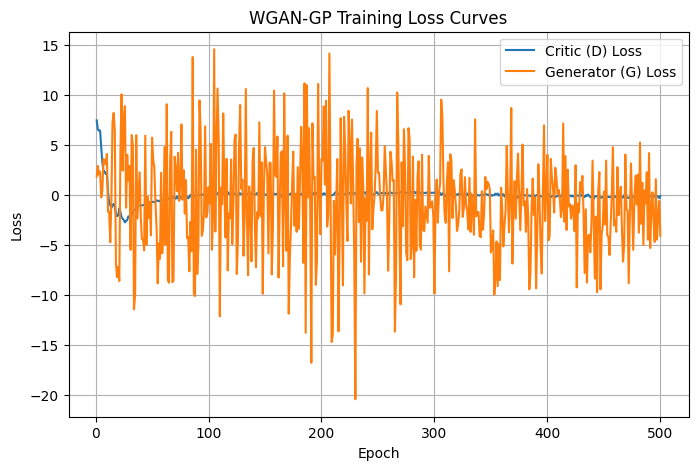

Total epochs plotted: 500


In [ ]:
# Cell 14
# Purpose: Plot Generator and Critic loss curves over training epochs.

import matplotlib.pyplot as plt

epochs = range(1, len(D_loss_history) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, D_loss_history, label="Critic (D) Loss")
plt.plot(epochs, G_loss_history, label="Generator (G) Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("WGAN-GP Training Loss Curves")
plt.legend()
plt.grid(True)

plt.show()

print("Total epochs plotted:", len(epochs))


Loaded checkpoint: better_wgan_gp_epoch_0500.pt | epoch: 500
Will generate: {'left': 1, 'right': 1}
Expected output shape per sample: (3, 1001) (C, T)
Generated shapes:
  left : (1, 3, 1001)
  right: (1, 3, 1001)
Value ranges (µV):
  left : min -5.0603532791137695 max 4.202963352203369
  right: min -5.0603532791137695 max 4.202963352203369


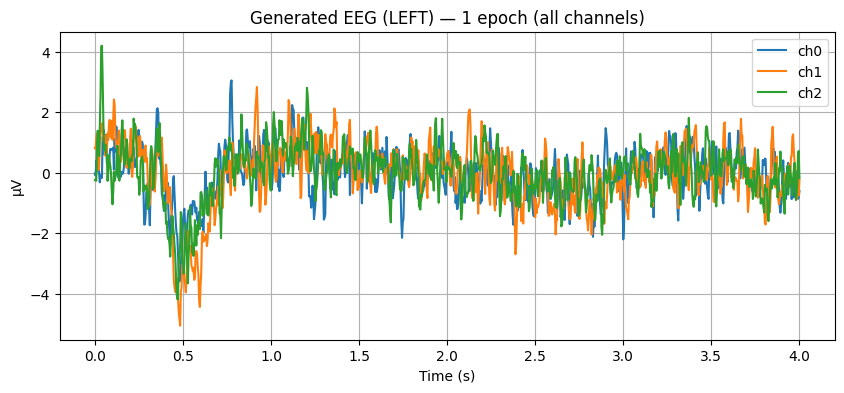

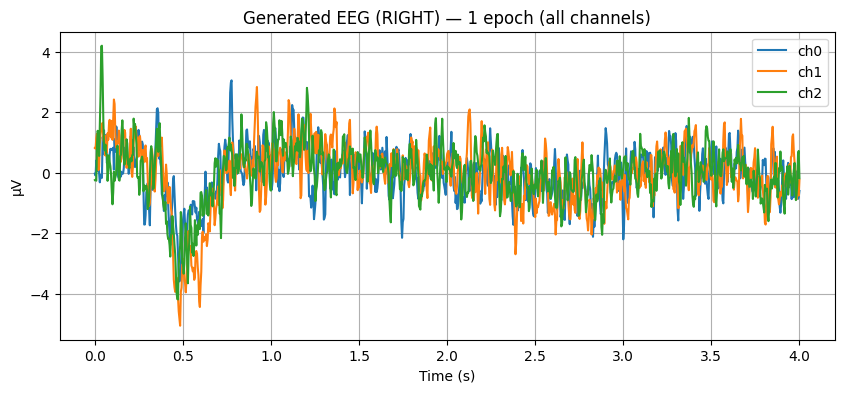

In [ ]:
# Cell 15
# Purpose: Load a saved checkpoint (Generator) and generate synthetic EEG epochs for left/right.
# Output: Prints shapes + shows one example waveform (all channels) for left and right.

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---- User controls ----
CKPT_PATH = Path("./checkpoints") / "better_wgan_gp_epoch_0500.pt"  # change to your checkpoint file
N_LEFT = 1   # how many left epochs to generate (change anytime)
N_RIGHT = 1  # how many right epochs to generate (change anytime)

# ---- Load checkpoint ----
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
G.load_state_dict(ckpt["generator_state"])
G.eval()

print("Loaded checkpoint:", CKPT_PATH.name, "| epoch:", ckpt.get("epoch", "unknown"))
print("Will generate:", {"left": N_LEFT, "right": N_RIGHT})
print("Expected output shape per sample:", (X.shape[1], X.shape[2]), "(C, T)")

# ---- Generate helper ----
@torch.no_grad()
def generate_epochs(n, label01: int):
    y = torch.full((n,), label01, dtype=torch.long, device=DEVICE)   # 0=left, 1=right
    z = torch.randn(n, Z_DIM, device=DEVICE)
    x = G(z, y)  # (n, C, T) in [-1,1]
    return x.detach().cpu().numpy()

# ---- Generate ----
X_fake_left  = generate_epochs(N_LEFT, 0)
X_fake_right = generate_epochs(N_RIGHT, 1)

print("Generated shapes:")
print("  left :", X_fake_left.shape)
print("  right:", X_fake_right.shape)

# ---- Convert back to microvolts for interpretability ----
# Your training normalized data to [-1,1] using CLIP_UV, so undo scaling:
X_fake_left_uv  = X_fake_left  * CLIP_UV
X_fake_right_uv = X_fake_right * CLIP_UV

print("Value ranges (µV):")
print("  left : min", float(X_fake_left_uv.min()),  "max", float(X_fake_left_uv.max()))
print("  right: min", float(X_fake_right_uv.min()), "max", float(X_fake_right_uv.max()))

# ---- Visualize 1 sample from each class (all channels) ----
t = np.linspace(TMIN, TMAX, X_fake_left_uv.shape[2])

def plot_one(epoch_uv, title):
    plt.figure(figsize=(10, 4))
    for ch in range(epoch_uv.shape[0]):
        plt.plot(t, epoch_uv[ch], label=f"ch{ch}")
    plt.xlabel("Time (s)")
    plt.ylabel("µV")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_one(X_fake_left_uv[0],  "Generated EEG (LEFT) — 1 epoch (all channels)")
plot_one(X_fake_right_uv[0], "Generated EEG (RIGHT) — 1 epoch (all channels)")


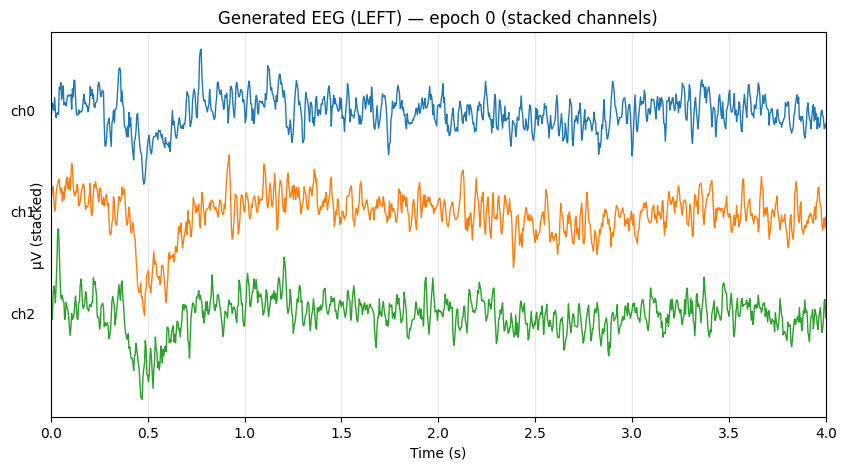

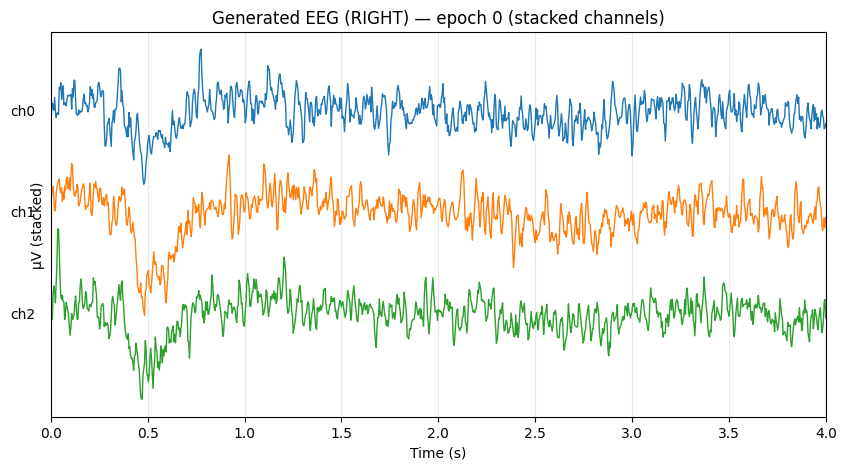

In [ ]:
# Cell 16
# Purpose: Plot generated EEG like MNE (channels separated, not overlapping).
# Output: Two stacked plots (LEFT and RIGHT), each channel on its own horizontal line.

import numpy as np
import matplotlib.pyplot as plt

# ---- choose which sample to display ----
IDX_LEFT = 0
IDX_RIGHT = 0

# Use the arrays created in Cell 15:
# X_fake_left_uv  : (N_left,  C, T) in microvolts
# X_fake_right_uv : (N_right, C, T) in microvolts

t = np.linspace(TMIN, TMAX, X_fake_left_uv.shape[2])

# Try to use real channel names if you have them; otherwise fallback
try:
    ch_names = epochs_eeg.ch_names  # if you still have epochs_eeg in memory
except Exception:
    ch_names = [f"ch{i}" for i in range(X_fake_left_uv.shape[1])]

def plot_stacked(epoch_uv: np.ndarray, title: str, sep_uv: float = None):
    """
    epoch_uv: (C, T) in microvolts
    sep_uv: vertical separation between channels in microvolts (auto if None)
    """
    C, Tn = epoch_uv.shape

    # Auto separation: based on robust amplitude so it doesn't overlap
    if sep_uv is None:
        robust_amp = np.percentile(np.abs(epoch_uv), 95)  # typical large amplitude
        sep_uv = max(robust_amp * 2.5, 5.0)               # at least 5 µV spacing

    offsets = np.arange(C)[::-1] * sep_uv  # top channel highest offset

    plt.figure(figsize=(10, 5))
    for i in range(C):
        y = epoch_uv[i] + offsets[i]
        plt.plot(t, y, linewidth=1.0)

        # channel label on the left
        plt.text(t[0] - 0.02*(TMAX - TMIN), offsets[i], ch_names[i],
                 va="center", ha="right")

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("µV (stacked)")
    plt.yticks([])  # hide y ticks because offsets are arbitrary
    plt.grid(True, alpha=0.3)
    plt.xlim(TMIN, TMAX)
    plt.show()

# ---- Plot LEFT and RIGHT (stacked) ----
plot_stacked(X_fake_left_uv[IDX_LEFT],  f"Generated EEG (LEFT) — epoch {IDX_LEFT} (stacked channels)")
plot_stacked(X_fake_right_uv[IDX_RIGHT], f"Generated EEG (RIGHT) — epoch {IDX_RIGHT} (stacked channels)")


After this is the testing process

In [1]:
# Cell 1 — Imports & setup
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import mne
from scipy.signal import welch
from scipy.stats import kurtosis

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda


In [2]:
# Cell 2 — Config (EDIT PATHS HERE)

# --- checkpoints ---
NORMAL_CKPT_PATH   = Path("runs/vanilla_improved/checkpoints/better_wgan_gp_epoch_0500.pt")
# ADAPTIVE_CKPT_PATH = Path("checkpoints/adaptive_wgan_gp_epoch_0200.pt")

# --- evaluation files (E-files) ---
# Put your extracted folder here:
DATA_DIR = Path("BCICIV_2b_gdf")

# You said eval files are 04E / 05E:
E_FILES = sorted(list(DATA_DIR.glob("*04E.gdf")) + list(DATA_DIR.glob("*05E.gdf")))
print("E files:", [p.name for p in E_FILES])
assert len(E_FILES) > 0, f"No 04E/05E files found under {DATA_DIR.resolve()}"

# --- preprocessing settings (match training notebook) ---
TMIN, TMAX = 0.0, 4.0
L_FREQ, H_FREQ = 0.5, 40.0
NOTCH_HZ = 50.0
EOG_REJECT_UV = 150.0
RESAMPLE_HZ = 250
CLIP_UV = 100.0

# E-file event used for epoching (BCIC uses 783 for "trial start" in many setups)
E_EPOCH_EVENT = "783"

# --- generator settings (must match training) ---
Z_DIM = 128
N_CLASSES = 2  # generator is conditional; labels are used for generation only
C = 3
T = int(RESAMPLE_HZ * (TMAX - TMIN)) + 1  # 250*4 + 1 = 1001

# --- generation ---
N_GEN_PER_CLASS = 256  # increase if you want more stable metrics

print("Expected (C,T):", (C, T))


E files: ['B0104E.gdf', 'B0105E.gdf', 'B0204E.gdf', 'B0205E.gdf', 'B0304E.gdf', 'B0305E.gdf', 'B0404E.gdf', 'B0405E.gdf', 'B0504E.gdf', 'B0505E.gdf', 'B0604E.gdf', 'B0605E.gdf', 'B0704E.gdf', 'B0705E.gdf', 'B0804E.gdf', 'B0805E.gdf', 'B0904E.gdf', 'B0905E.gdf']
Expected (C,T): (3, 1001)


In [3]:
# Cell 3 — Generator definition (COPIED FROM YOUR vanilla/adaptive notebooks)

class Generator(nn.Module):
    def __init__(self, z_dim, n_classes, C, T):
        super().__init__()
        self.embed = nn.Embedding(n_classes, z_dim)
        self.net = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(),
            nn.Linear(512, C * T),
            nn.Tanh(),
        )
        self.C, self.T = C, T

    def forward(self, z, y):
        z = z + self.embed(y)
        return self.net(z).view(-1, self.C, self.T)

print("Generator defined.")


Generator defined.


In [4]:
# Cell 4 — Load generator weights (FIXED for your checkpoint keys)

def load_generator(ckpt_path: Path) -> nn.Module:
    assert ckpt_path.exists(), f"Missing checkpoint: {ckpt_path.resolve()}"

    G = Generator(Z_DIM, N_CLASSES, C, T).to(device)
    ckpt = torch.load(str(ckpt_path), map_location=device)

    if not isinstance(ckpt, dict):
        raise TypeError("Checkpoint must be a dict.")

    # ✅ Your checkpoint uses 'generator_state'
    for key in ["generator_state", "G_state", "G_state_dict", "generator", "gen_state", "state_dict"]:
        if key in ckpt and isinstance(ckpt[key], dict):
            G.load_state_dict(ckpt[key], strict=True)
            G.eval()
            return G

    # fallback: whole dict is a state_dict
    if all(isinstance(v, torch.Tensor) for v in ckpt.values()):
        G.load_state_dict(ckpt, strict=True)
        G.eval()
        return G

    raise KeyError(f"Cannot find generator weights in keys: {list(ckpt.keys())}")

G_normal = load_generator(NORMAL_CKPT_PATH)
# G_adapt  = load_generator(ADAPTIVE_CKPT_PATH)

print("Loaded normal:", NORMAL_CKPT_PATH)
# print("Loaded adaptive:", ADAPTIVE_CKPT_PATH)


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL pathlib.PosixPath was not an allowed global by default. Please use `torch.serialization.add_safe_globals([pathlib.PosixPath])` or the `torch.serialization.safe_globals([pathlib.PosixPath])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
# Cell 5 — Preprocess E-file into epochs (label-free)
# FIX: use annotation mapping correctly + apply SAME normalization as training (Option A)

def preprocess_eval_E_file(gdf_path: Path) -> np.ndarray:
    raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)

    # mark EOG channels (so picks="eeg" excludes them)
    for ch in raw.ch_names:
        if "EOG" in ch:
            raw.set_channel_types({ch: "eog"})

    raw.filter(L_FREQ, H_FREQ, fir_design="firwin", verbose=False)
    raw.notch_filter(NOTCH_HZ, verbose=False)

    events, event_id_map = mne.events_from_annotations(raw, verbose=False)

    # Choose a usable event description for epoching (E-files can differ)
    # Priority: trial-start 783, then 768, then class cues 769/770
    preferred = ["783", "768", "769", "770"]
    chosen_desc = None
    for desc in preferred:
        if desc in event_id_map:
            chosen_desc = desc
            break

    if chosen_desc is None:
        # Helpful debug: show what annotations exist in this file
        raise ValueError(
            f"No expected events found in {gdf_path.name}. "
            f"Available annotation keys: {sorted(event_id_map.keys())}"
        )

    chosen_event_id = {chosen_desc: event_id_map[chosen_desc]}

    epochs = mne.Epochs(
        raw,
        events,
        event_id=chosen_event_id,
        tmin=TMIN,
        tmax=TMAX,
        picks="eeg",
        preload=True,
        baseline=None,
        verbose=False,
    )

    X = epochs.get_data()            # (N, C, T) in volts
    X = X * 1e6                      # volts → microvolts
    X = np.clip(X, -CLIP_UV, CLIP_UV)
    X = (X / CLIP_UV).astype(np.float32)

    return X

X_eval_list = []
for f in E_FILES:
    print("Processing:", f.name)
    X_i = preprocess_eval_E_file(f)
    print("  epochs:", X_i.shape[0], "shape:", X_i.shape)
    X_eval_list.append(X_i)

X_eval = np.concatenate(X_eval_list, axis=0).astype(np.float32)
print("\nX_eval:", X_eval.shape)

# label-free (E files do not provide left/right labels)
y_eval = -1 * np.ones((len(X_eval),), dtype=np.int64)
print("y_eval:", y_eval.shape, "unique:", np.unique(y_eval))

print("Ranges (X_eval norm) min/max:", float(X_eval.min()), float(X_eval.max()))


Processing: B0104E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0105E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0204E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 120 shape: (120, 3, 1001)
Processing: B0205E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0304E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0305E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0404E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0405E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0504E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0505E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0604E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0605E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0704E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0705E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0804E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0805E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0904E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)
Processing: B0905E.gdf


/tmp/ipykernel_2402/1006541889.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


  epochs: 160 shape: (160, 3, 1001)

X_eval: (2840, 3, 1001)
y_eval: (2840,) unique: [-1]
Ranges (X_eval norm) min/max: -0.49538514018058777 0.48025211691856384


In [ ]:
# Cell 6 — Generate fake EEG from each generator (conditional LEFT/RIGHT)
# Even though E-files are unlabeled, we can still generate both classes and compare distribution-level metrics.

@torch.no_grad()
def generate_fake(G: nn.Module, n_per_class: int):
    Xs, ys = [], []
    for cls in range(N_CLASSES):
        z = torch.randn(n_per_class, Z_DIM, device=device)
        y = torch.full((n_per_class,), cls, dtype=torch.long, device=device)
        x = G(z, y)  # (B,C,T)
        Xs.append(x.detach().cpu().numpy())
        ys.append(y.detach().cpu().numpy())
    return np.concatenate(Xs, axis=0).astype(np.float32), np.concatenate(ys, axis=0).astype(np.int64)

Xn_fake, yn_fake = generate_fake(G_normal, N_GEN_PER_CLASS)
# Xa_fake, ya_fake = generate_fake(G_adapt,  N_GEN_PER_CLASS)

print("Normal fake:", Xn_fake.shape, "counts:", dict(zip(*np.unique(yn_fake, return_counts=True))))
# print("Adapt  fake:", Xa_fake.shape, "counts:", dict(zip(*np.unique(ya_fake, return_counts=True))))


Normal fake: (512, 3, 1001) counts: {np.int64(0): np.int64(256), np.int64(1): np.int64(256)}


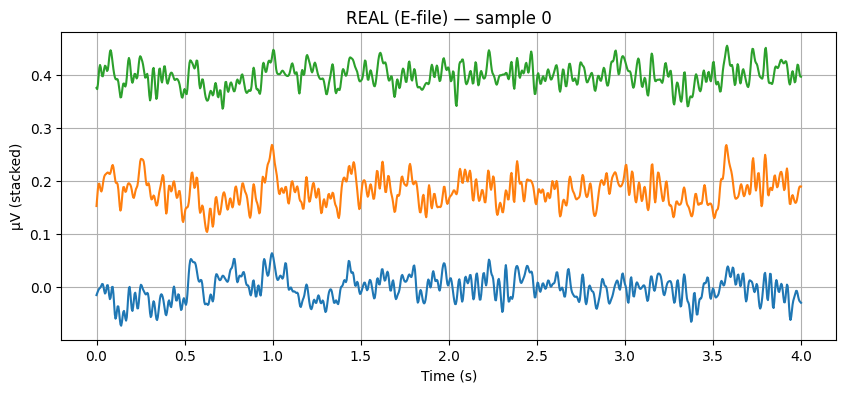

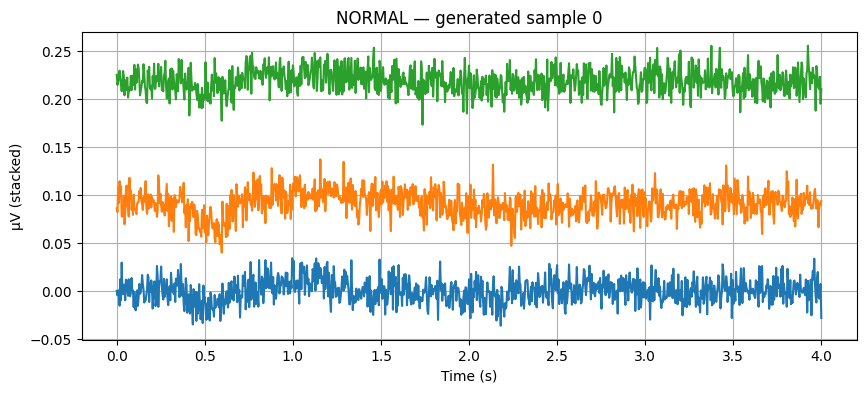

In [ ]:
# Cell 7 — Quick sanity plot (stacked channels)

FS = RESAMPLE_HZ

def plot_stacked(x, title):
    t = np.arange(x.shape[1]) / FS
    plt.figure(figsize=(10, 4))
    offset = 0.0
    for ch in range(x.shape[0]):
        plt.plot(t, x[ch] + offset)
        offset += (np.max(np.abs(x[ch])) + 1e-6) * 2.5
    plt.xlabel("Time (s)")
    plt.ylabel("µV (stacked)")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_stacked(X_eval[0], "REAL (E-file) — sample 0")
plot_stacked(Xn_fake[0], "NORMAL — generated sample 0")
# plot_stacked(Xa_fake[0], "ADAPTIVE — generated sample 0")


In [ ]:
# Cell 9 — Evaluate (REAL vs NORMAL only) using robust, size-invariant metrics
# (Adaptive model completely removed)

import numpy as np
from scipy.signal import welch

# -------------------------
# Robust metrics (N_real can differ from N_fake)
# -------------------------
def mean_log_psd(X, fs, max_samples=300):
    """
    X: (N,C,T)
    returns: mean log-PSD per channel (C,F)
    """
    N = min(len(X), max_samples)
    idx = np.random.choice(len(X), N, replace=False) if len(X) > N else np.arange(len(X))

    psd_acc = []
    for i in idx:
        ch_psd = []
        for ch in range(X.shape[1]):
            f, Pxx = welch(X[i, ch], fs=fs, nperseg=min(256, X.shape[2]))
            ch_psd.append(np.log(Pxx + 1e-8))
        psd_acc.append(ch_psd)

    psd_acc = np.asarray(psd_acc)          # (N,C,F)
    return f, psd_acc.mean(axis=0)         # (C,F)

def log_psd_mse(X_real, X_fake, fs):
    f_r, P_r = mean_log_psd(X_real, fs)
    f_f, P_f = mean_log_psd(X_fake, fs)
    # assume same freq bins (same fs, same nperseg)
    return float(np.mean((P_f - P_r) ** 2))

def global_percentile_mae(X_real, X_fake, percentiles=(5, 50, 95), max_points=2_000_000):
    """
    Compare global amplitude distribution percentiles.
    Flattens across samples+time per channel, then compares percentiles.
    Returns mean absolute error over channels and percentiles.
    """
    def flatten_cap(X):
        # X: (N,C,T) -> (C, N*T)
        C = X.shape[1]
        flat = X.transpose(1, 0, 2).reshape(C, -1)
        if flat.shape[1] > max_points:
            idx = np.random.choice(flat.shape[1], max_points, replace=False)
            flat = flat[:, idx]
        return flat

    r = flatten_cap(X_real)
    f = flatten_cap(X_fake)

    errs = []
    for p in percentiles:
        pr = np.percentile(r, p, axis=1)  # (C,)
        pf = np.percentile(f, p, axis=1)  # (C,)
        errs.append(np.mean(np.abs(pf - pr)))
    return float(np.mean(errs))

# -------------------------
# IMPORTANT: Make sure units match (real vs fake)
# Fake (Xn_fake) is typically already in [-1, 1]. Real (X_eval) might be microvolts or normalized.
# We'll prefer X_eval_norm if you created it (Cell 29). Otherwise, fall back to X_eval.
# -------------------------
X_real = X_eval_norm if "X_eval_norm" in globals() else X_eval
X_fake = Xn_fake

print("Shapes:", X_real.shape, X_fake.shape)
print("Ranges (real min/max):", float(X_real.min()), float(X_real.max()))
print("Ranges (fake min/max):", float(X_fake.min()), float(X_fake.max()))

print("log_psd_mse (lower better):", log_psd_mse(X_real, X_fake, FS))
print("global_percentile_mae (lower better):", global_percentile_mae(X_real, X_fake))


Shapes: (2840, 3, 1001) (512, 3, 1001)
Ranges (real min/max): -0.49538514018058777 0.48025211691856384
Ranges (fake min/max): -0.23372985422611237 0.24013397097587585
log_psd_mse (lower better): 22.453367233276367
global_percentile_mae (lower better): 0.009271777234971523
